# BitBIRCH best practices - RDKit

This is a notebook works as an example how to use data-informed parameters for the BitBirch algorithm to obtain better results.
The RDKit fingerprints require an extra step to refine the largest cluster.

- [BitBIRCH: efficient clustering of large molecular libraries](https://doi.org/10.1039/D5DD00030K)
- [BitBIRCH Clustering Refinement Strategies](https://doi.org/10.1021/acs.jcim.5c00627)
- [BitBIRCH-Lean (preprint)](https://www.biorxiv.org/content/10.1101/2025.10.22.684015v1)
- [BitBIRCH best practices guidelines](https://ADD_WHEN_PUBLISHED)

Please reach out to one of the following with any questions or concerns. 

- Ramon Alain Miranda Quintana: `quintana At chem.ufl.edu`
- Kenneth Lopez Perez: `klopezperez At chem.ufl.edu`
- Ignacio Pickering: `ipickering At chem.ufl.edu`
- Krisztina Zsigmond: `kzsigmond At ufl.edu`
- Miroslav Lzicar: `miroslav.lzicar At deepmedchem.com`

## Set Up

First lets install the BitBirch-Lean package (if you have not already done so). To do
this, run the following commands in your terminal:

```
git clone https://github.com/mqcomplab/bblean.git
cd bblean
pip install -v .
```

Lets import the `bblean` package and some bblean modules, which we will use throughout
this example.

In [1]:
import bblean
import bblean.plotting as plotting
import bblean.analysis as analysis
import bblean.similarity as iSIM
import numpy as np
import matplotlib.pyplot as plt
import os

# Functions to reproduce the figures in the best practices guidelines paper
from best_practices_plots import plot_cluster_refinement, clusters_pop_plot, sampled_MSC, plot_threshold_scan
from best_practices_functions import threshold_scan, recluster_iteration_metrics

/blue/rmirandaquintana/klopezperez/bblean/bblean/similarity.py:100: UserWarning: C++ optimized similarity calculations not available, falling back to python implementation
  warnings.warn(


Let's download some smiles for this example

In [14]:
os.system("wget -q https://zenodo.org/records/17796465/files/chembl.smi")

0

In [15]:
smiles = bblean.load_smiles("chembl.smi")

# By default the fps created are of the "ecfp4" kind. Here we use "rdkit"
fps = bblean.fps_from_smiles(smiles, pack=True, n_features=2048, kind="rdkit")
print(f"Shape: {fps.shape}, DType: {fps.dtype}")

Shape: (2764425, 256), DType: uint8


## Clustering fingerprints

First to define an optimal threshold we will take a look into the average similarity of
the fingerprints we want to cluster. For this we will use the iSIM formalism which can
calculate the average similarity with linear complexity. You can notice how this value differs significantly from the one obtained in the other notebook where we use ECFP4 fingerprints.

In [16]:
isim = iSIM.jt_isim_packed(fps)
print(f"Average similarity: {isim:.4f}")

Average similarity: 0.3177


Now, we will estimate the standard deviation of the similarities using a stratified
sample from our data set.

In [17]:
isim_sigma = iSIM.estimate_jt_std(fps, n_samples=50)
print(f"Estimated std of similarity: {isim_sigma:.4f}")

Estimated std of similarity: 0.1029


We have already identified that for most databases 3.5 or 4 isim sigmas over the global isim gives good clustering results.

In [48]:
# Initialize the BitBirch tree. In general, diameter is the best merge criterion for
optimal_threshold = isim + 3.5 * isim_sigma
bb_tree = bblean.BitBirch(branching_factor = 1024, 
                          threshold=optimal_threshold, 
                          merge_criterion="diameter")

# Cluster the packed fingerprints (By default all bblean functions take packed fingerprints)
bb_tree.fit(fps)

BitBirch(threshold=0.6778597081973251, branching_factor=1024, merge_criterion='diameter')

Lets analyze the results to check the number of singletons

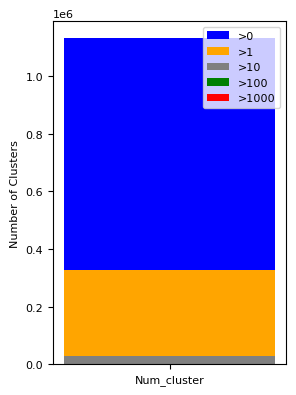

In [49]:
clusters = bb_tree.get_cluster_mol_ids()
clusters_pop_plot(clusters)

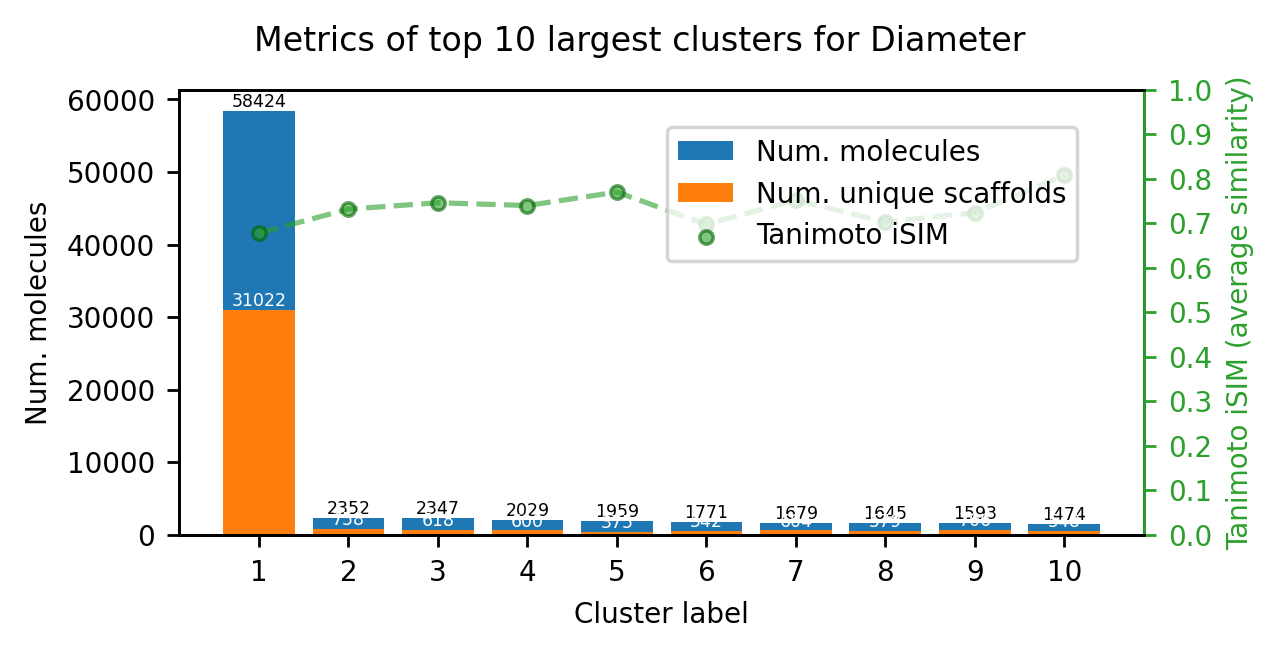

In [50]:
# First we run a cluster analysis on the resulting ids
ca = analysis.cluster_analysis(clusters, fps, smiles, top = 10)

# Afterwards we can use the utility functions on the bblean.plotting module
plotting.summary_plot(ca, title="Diameter")
plt.show()

We can take a look at some of the structures to see if there they fit they make sense in terms of chemical structure.

Sample of molecules in the cluster 0, population 58424:


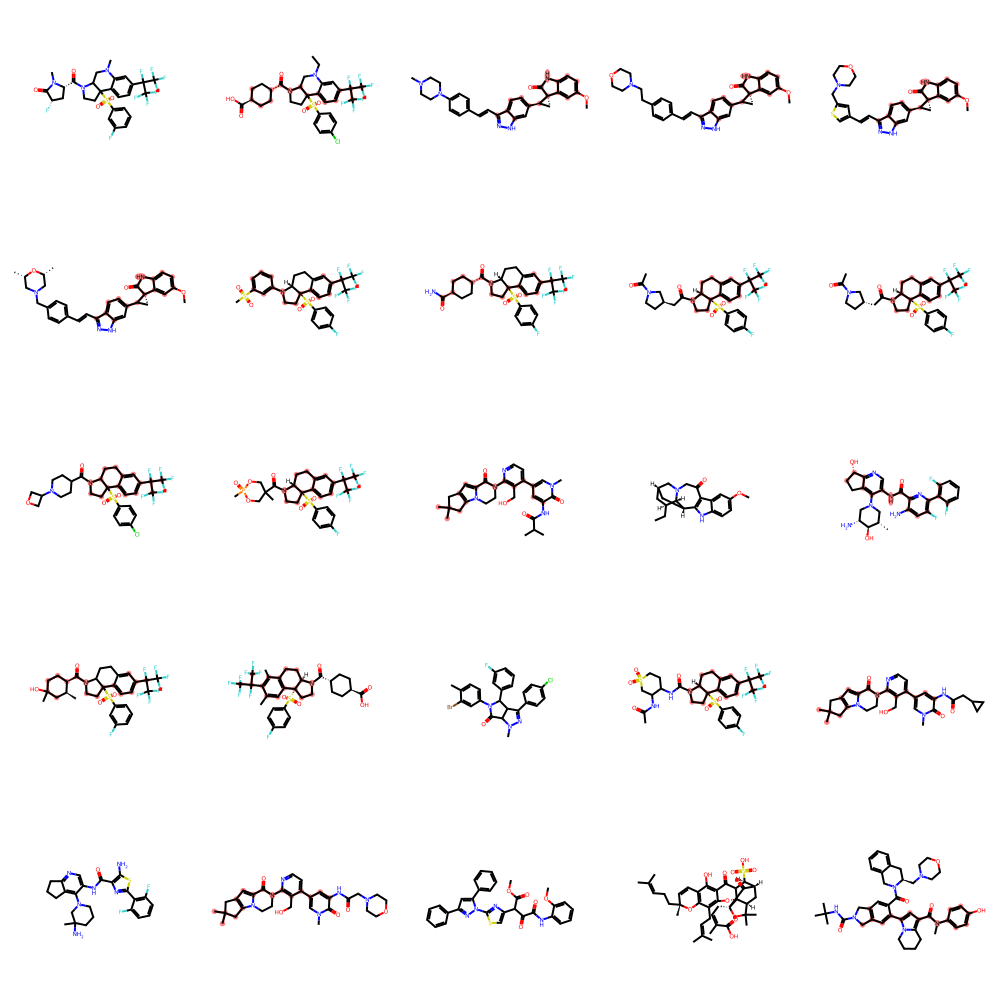

MCS:


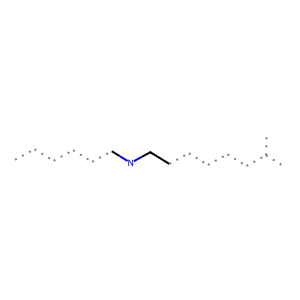

In [51]:
to_visualize = 0 # Change this to visualize other clusters
img1, img2 = sampled_MSC(cluster=clusters[to_visualize], smiles = smiles, n_samples=25)
print(f"Sample of molecules in the cluster {to_visualize}, population {len(clusters[to_visualize])}:")
display(img1)
print(f"MCS:")
display(img2)

It is evident that there is a big cluster with structures that do not go together. To solve this, we are going to use the refinement method `refine_inplace`, this method breaks apart the big cluster and passes the molecules through the tree. Note that we increase the threshold to prevent the reformation of the big cluster. It is only necessary when there is an overly-large cluster.

In [52]:
bb_tree.threshold += 1 * isim_sigma  # Increase threshold to avoid reforming large clusters
bb_tree.refine_inplace(fps)

BitBirch(threshold=0.7807536475095639, branching_factor=1024, merge_criterion='diameter')

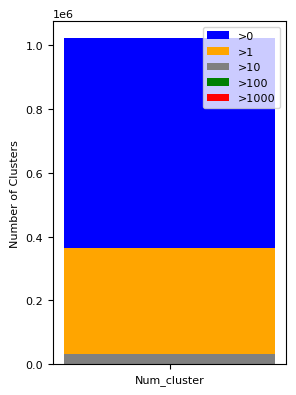

In [53]:
clusters = bb_tree.get_cluster_mol_ids()
clusters_pop_plot(clusters)

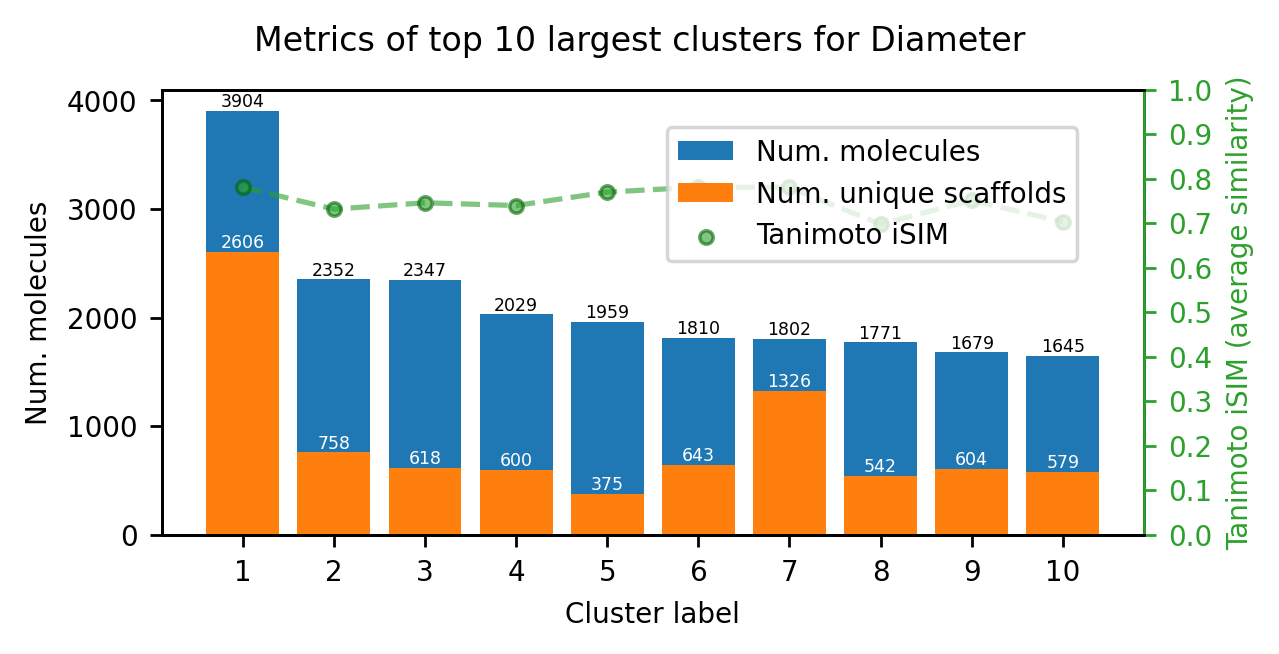

In [54]:
# First we run a cluster analysis on the resulting ids
ca = analysis.cluster_analysis(clusters, fps, smiles, top = 10)

# Afterwards we can use the utility functions on the bblean.plotting module
plotting.summary_plot(ca, title="Diameter")
plt.show()

Now that we took care of the large cluster, we can still see that there is a high number of singletons. For this we are going to use the reclustering iteration to see if we can take this number down, we use an extra threshold of 0.5 standard deviation of the similarities to prevent the formation of lower quality clusters. We decided to use 0.5 in this case because the threshold is already high from the refinement step.  

In [55]:
bb_tree.recluster_inplace(iterations=3, extra_threshold=0.25*isim_sigma)

BitBirch(threshold=0.8579241019937428, branching_factor=1024, merge_criterion='diameter')

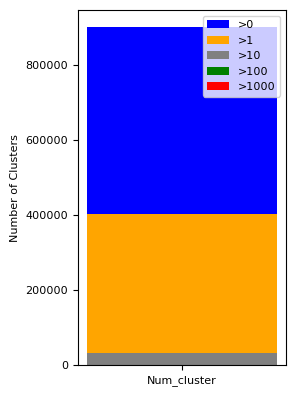

In [56]:
clusters = bb_tree.get_cluster_mol_ids()
clusters_pop_plot(clusters)

We reduced some of the singletons, however not fully. We have to also consider that the encoding of the RDKit fingerprints might highly influence this behavior. 

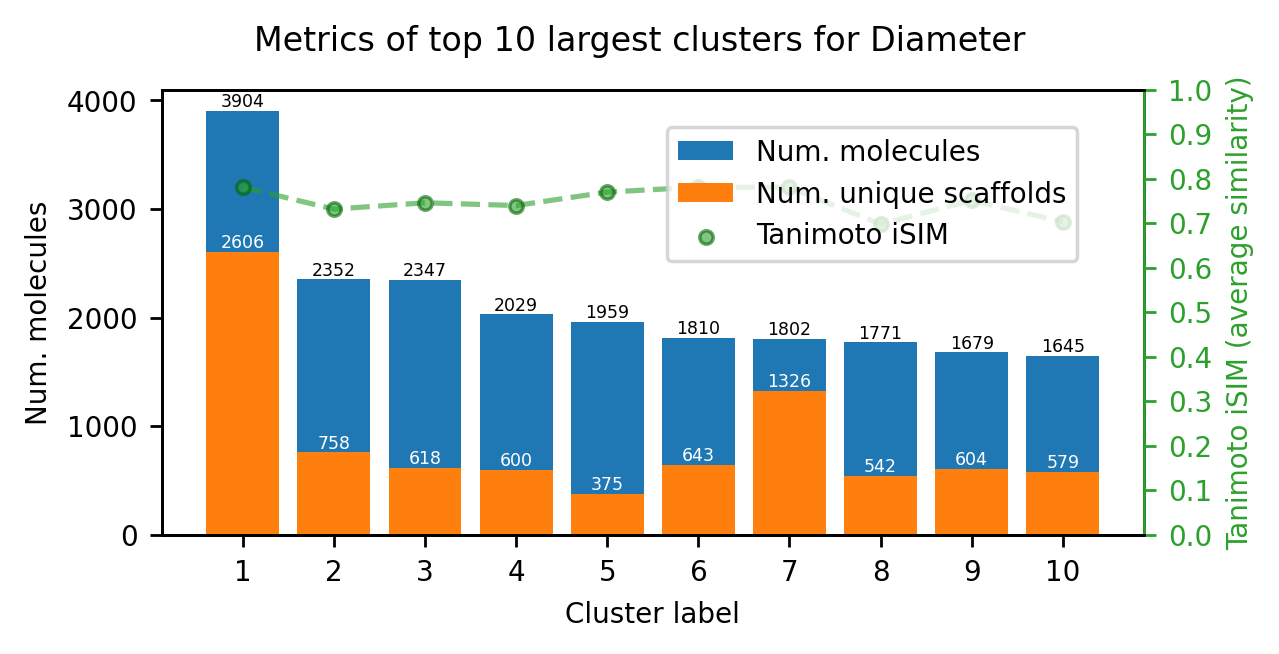

In [57]:
# First we run a cluster analysis on the resulting ids
ca = analysis.cluster_analysis(clusters, fps, smiles, top = 10)

# Afterwards we can use the utility functions on the bblean.plotting module
plotting.summary_plot(ca, title="Diameter")
plt.show()

Sample of molecules in the cluster 3, population 2029:


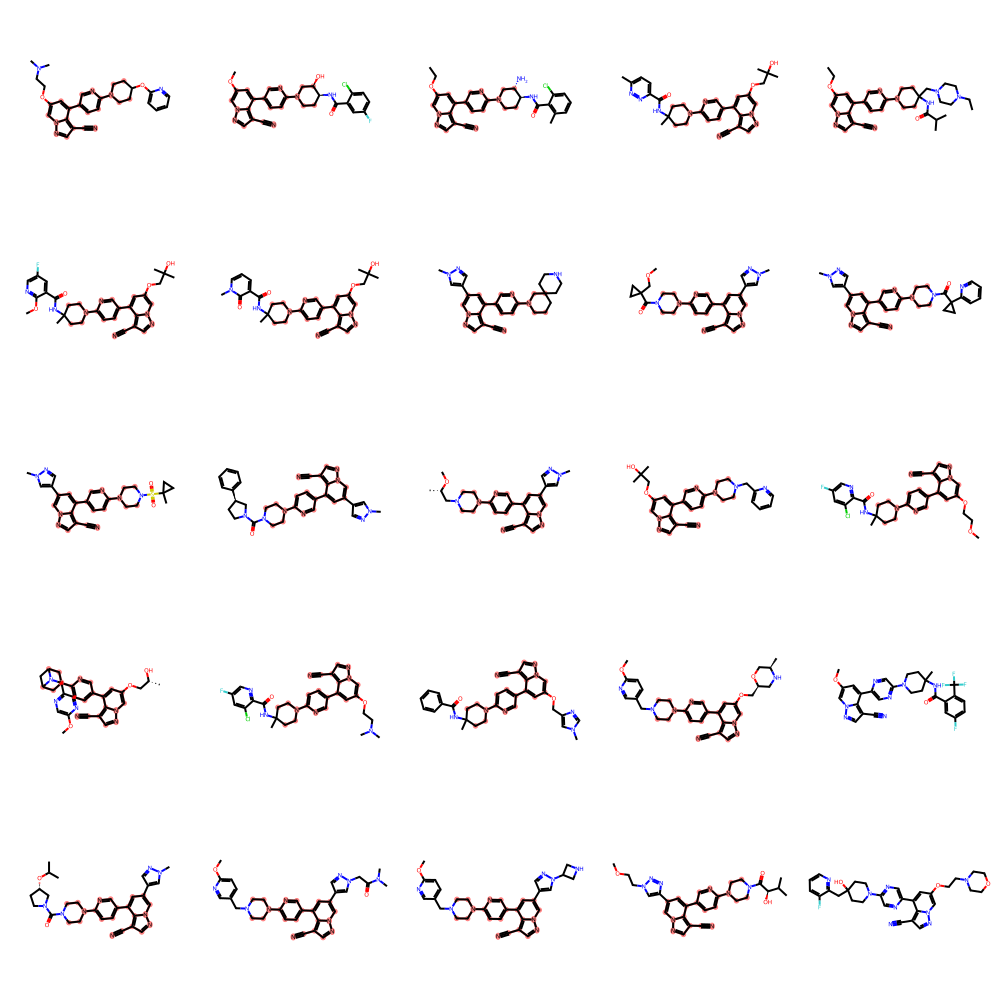

MCS:


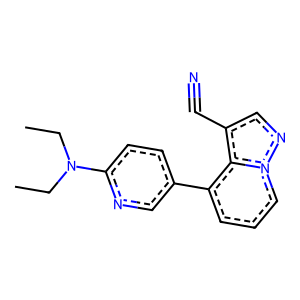

In [61]:
to_visualize = 3 # Change this to visualize other clusters
img1, img2 = sampled_MSC(cluster=clusters[to_visualize], smiles = smiles, n_samples=25)
print(f"Sample of molecules in the cluster {to_visualize}, population {len(clusters[to_visualize])}:")
display(img1)
print(f"MCS:")
display(img2)